# Hands-on Lithium Ion Battery (LIB) modelling

Installing libraries

In [1]:
# %pip install numpy
# %pip install scipy
# %pip install matplotlib
# %pip install pybamm==22.3

In [2]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

Model set up

In [3]:
# set the model type
model = pybamm.lithium_ion.NewmanTobias()

# set the default model geometry
geometry = model.default_geometry

Uncomment the following plot to show all the model paramenters

In [4]:
# format_str = '{:<75}  {:>20}'
# print(format_str.format('PARAMETER', 'VALUE'))
# print("-"*97)
# for key, value in model.default_parameter_values.items():
#     try:
#         print(format_str.format(key, value))
#     except TypeError:
#         print(format_str.format(key, value.__str__()))

In [5]:
model.default_var_pts

{'R_n': 30,
 'R_p': 30,
 'r_n': 20,
 'r_p': 20,
 'x_n': 20,
 'x_p': 20,
 'x_s': 20,
 'y': 10,
 'z': 10}

Let's chage the nominal capacity

In [6]:
# set the default model parameters
# param = model.default_parameter_values
param = pybamm.ParameterValues("Chen2020")
# NOMINAL_Q = 2.0 # [Ah]
# param['Nominal cell capacity [A.h]'] = NOMINAL_Q  
# param['Cell volume [m3]'] = 7.8e-06*2
param["Current function [A]"] = "[input]" # [A] will be a model input

# set the parameters for the model and the geometry
param.process_model(model)
param.process_geometry(geometry)

# # mesh the domains
# mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# # discretise the model equations
# disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
# disc.process_model(model)
submesh_types = {
    "negative electrode": pybamm.Uniform1DSubMesh,
    "separator": pybamm.Uniform1DSubMesh,
    "positive electrode": pybamm.Uniform1DSubMesh,
    "negative particle": pybamm.Uniform1DSubMesh,
    "positive particle": pybamm.Uniform1DSubMesh,
    'negative particle size': pybamm.Uniform1DSubMesh,
    'positive particle size': pybamm.Uniform1DSubMesh,
    "current collector": pybamm.SubMesh0D
}

var = pybamm.standard_spatial_vars
var_pts = {var.x_n: 60, var.x_s: 30, var.x_p: 60, var.r_n: 60, var.r_p: 60}
mesh = pybamm.Mesh(geometry, submesh_types, var_pts)
spatial_methods = {
    'current collector': pybamm.ZeroDimensionalSpatialMethod(),
    "macroscale": pybamm.FiniteVolume(),
    "negative particle": pybamm.FiniteVolume(),
    "positive particle": pybamm.FiniteVolume(),
}
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

In [7]:
NOMINAL_Q = param['Nominal cell capacity [A.h]'] 

Now lets discharge the battery per 1h



In [8]:
# Lets use the default solver to compute the discharge curve
solver = pybamm.CasadiSolver()
n = 3601 # how many point to evaluate
t_eval = np.linspace(0, 3600, n) # [s]
solution = solver.solve(model, t_eval, inputs={'Current function [A]': NOMINAL_Q /1})

lets plot the result

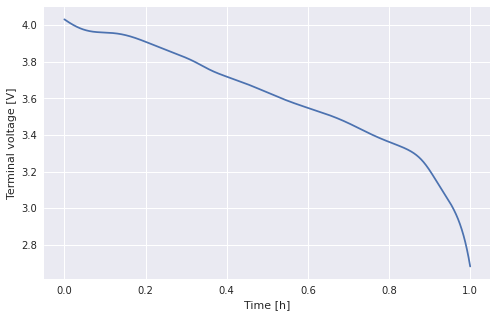

In [9]:
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(8,5))

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

## cumpute V profile ad different C-rate

In [10]:
C_RATE  = NOMINAL_Q /1.
C_RATES = [3, 2, 1.5, 1, 0.75, 0.5, 0.25, 0.1, 0.05, 0.01, 0.001]

times = []
voltages = []

for c_rate in C_RATES:
    t_eval = np.linspace(0, 4000/c_rate, max(500, int(50000*c_rate)) )
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE*c_rate})
    times.append(
        solution["Time [h]"].entries
    )
    voltages.append(
        solution["Terminal voltage [V]"].entries
    )
    print(f"C-Rate {c_rate:>6}: Discharged in {times[-1].max():>6.3g} h")

C-Rate      3: Discharged in  0.334 h
C-Rate      2: Discharged in  0.503 h
C-Rate    1.5: Discharged in  0.673 h
C-Rate      1: Discharged in   1.01 h
C-Rate   0.75: Discharged in   1.35 h
C-Rate    0.5: Discharged in   2.03 h
C-Rate   0.25: Discharged in   4.07 h
C-Rate    0.1: Discharged in   10.2 h
C-Rate   0.05: Discharged in   20.4 h
C-Rate   0.01: Discharged in    102 h
C-Rate  0.001: Discharged in 1.02e+03 h


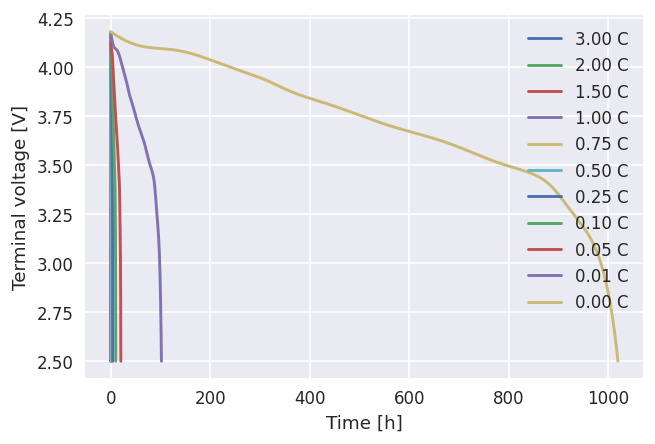

In [11]:
fig = plt.figure(figsize=(6,4), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    for i, c_rate in enumerate(C_RATES):
        ax.plot(times[i], voltages[i], label=f'{c_rate:1.2f} C')
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

In [12]:
from scipy.integrate import trapz

In [13]:

def get_energy(V, I, t):
    return trapz(V*I, x=t)

def get_cell_volume_and_mass(param):
    vol = param['Cell volume [m3]']
    t = 0
    rho = 0
    componets = [
        'Negative electrode',
        'Negative current collector',
        'Positive electrode',
        'Positive current collector',
        'Separator'
    ]
    for comp in componets:
        rho_ = param[comp+' density [kg.m-3]']
        t_ = param[comp+' thickness [m]']
        rho += rho_*t_
        t += t_
    rho /= t
    mass = rho*vol
    return vol, mass

CELL_VOL, CELL_MASS = get_cell_volume_and_mass(param)
specifc_power = []
specifc_energy = []
for i, (c_rate, v, t) in enumerate(zip(C_RATES, voltages, times)):
    energy = get_energy(v, c_rate*C_RATE, t*3600)
    power = energy / (t.max()*3600)
    specifc_energy.append(energy/CELL_MASS)
    specifc_power.append(power/CELL_MASS)

In [14]:
specifc_energy

[955634.8448363809,
 975089.6164137349,
 986377.3020939636,
 999530.100837254,
 1007283.766220032,
 1016380.8584968647,
 1027681.706750522,
 1036031.8178194483,
 1039100.6705064909,
 1041621.2468829365,
 1042192.6686281738]

In [15]:
specifc_power

[794.1038690424934,
 538.0013223726676,
 407.29103004162835,
 274.4949924536138,
 207.1888460060999,
 139.15532109290018,
 70.20759352815092,
 28.26110232619646,
 14.161861611755587,
 2.837424309413472,
 0.28385648461763835]

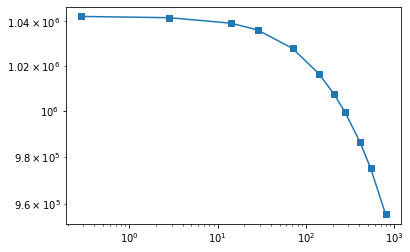

In [16]:
plt.loglog(specifc_power, specifc_energy, '-s')

In [17]:
    
    c_rate = 2

    C_RATE  = NOMINAL_Q /1.

    t_eval = np.linspace(0, 3600/c_rate +300, 3000)
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE*c_rate})
    times.append(
        solution["Time [h]"].entries
    )
    voltages.append(
        solution["Terminal voltage [V]"].entries
    )
    

## Find the 1 C-rate current

We are going to use a old but simple method but effective metod to find the exact value of current to discharge the battery afte 1 hour with a cut of current of 3.3 V.
We are going to use [Secant Method](https://en.wikipedia.org/wiki/Secant_method) to find the zero of the follinwing target function:

$ f(i) = V_{end}(i) - V_{cut-off} $ 

> Note: a battery is discharge when the terminal voltage cross the cut-off value

In [18]:
# from scipy.optimize import differential_evolution # genetic algorithm optimizer

# CUTOFF_V = 3.3 
# i_min = NOMINAL_Q * 0.6/ 1.
# i_max = NOMINAL_Q * 1.5 / 1.

# def f_target(i):
#     solution = solver.solve(model, t_eval, inputs={'Current function [A]': i})
#     V_new = solution["Terminal voltage [V]"].entries[-1]
#     return V_new-CUTOFF_V

# differential_evolution(f_target, bounds=[(i_min, i_max)])

In [ ]:
from scipy.interpolate import interp1d

CUTOFF_V = 3.0

i_0 = NOMINAL_Q * 0.8/ 1.
i_1 = NOMINAL_Q * 1.1 / 1.

def f_target(t):
    return t-1

def get_cut_off_time(V, t):
    # diff = np.abs(V-CUTOFF_V)
    # indx = np.where(diff == diff.min())[0]
    # return t[indx][0]
    f_int = interp1d(V, t)
    return f_int(CUTOFF_V)

t_eval = np.linspace(0, 7200, 7201)
solution_0 = solver.solve(model, t_eval, inputs={'Current function [A]': i_0})
tc_0 = get_cut_off_time(solution_0["Terminal voltage [V]"].entries, 
                        solution_0["Time [h]"].entries ) 
solution_1 = solver.solve(model, t_eval, inputs={'Current function [A]': i_1})
tc_1= get_cut_off_time(solution_1["Terminal voltage [V]"].entries, 
                        solution_1["Time [h]"].entries ) 

# The loop end when diffence between two consecutive aptempt are less that 5% 
n_int = 0
while abs(tc_0-tc_1) > 0.001:
    i_new = i_1 - f_target(tc_1)*(i_1-i_0) / (f_target(tc_1)- f_target(tc_0))
    solution = solver.solve(model, t_eval, inputs={'Current function [A]': i_new})
    tc_new= get_cut_off_time(solution["Terminal voltage [V]"].entries, 
                             solution["Time [h]"].entries )
    print(f"[{n_int+1}]\ti_new: {i_new:1.5g} A\ttc_new: {tc_new:1.5g} h") 
    i_0 = i_1
    i_1 = i_new
    tc_0 = tc_1
    tc_1 = tc_new
    n_int += 1
C_RATE = i_1
print(f"C-rate current = {C_RATE} A")

Let's plot the result

In [ ]:
t_eval = np.linspace(0, 3600, 361)
solution_old = solver.solve(model, t_eval, inputs={'Current function [A]': NOMINAL_Q/1.})
solution = solver.solve(model, t_eval, inputs={'Current function [A]': C_RATE})

time_old = solution_old["Time [h]"].entries
voltage_old = solution_old["Terminal voltage [V]"].entries
time = solution["Time [h]"].entries
voltage = solution["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(6,4), dpi=120)

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time_old, voltage_old, label='Nominal')
    ax.plot(time, voltage, label='1 C-rate')
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")
    ax.legend()

plt.show()

In [ ]:
np.linspace(0, 7200, 181)

In [ ]:
solution_1["Time [h]"].entries

In [ ]:
time = solution_0["Time [h]"].entries
voltage = solution_0["Terminal voltage [V]"].entries
time_1 = solution_1["Time [h]"].entries
voltage_1 = solution_1["Terminal voltage [V]"].entries

fig = plt.figure(figsize=(8,5))

with plt.style.context('seaborn'):
    ax = fig.add_subplot(111)
    ax.plot(time, voltage)
    ax.plot(time_1, voltage_1)
    ax.set_xlabel("Time [h]")
    ax.set_ylabel("Terminal voltage [V]")

plt.show()

In [ ]:
# Solution with current = 0.68
old_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 0.68})
old_time = old_solution["Time [h]"].entries
old_voltage = old_solution["Terminal voltage [V]"].entries

# Solution with current = 1.4
new_solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1.4})
new_time = new_solution["Time [h]"].entries
new_voltage = new_solution["Terminal voltage [V]"].entries

plt.plot(old_time, old_voltage, lw=2, label="Current = 0.68")
plt.plot(new_time, new_voltage, lw=2, label="Current = 1.4")
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
solution.plot()